# Dependencias

In [43]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split
from pathlib import Path
from keras.layers import *
from keras.models import *

In [9]:
path = Path.cwd().parent / 'data' / 'UTKFace'
files = os.listdir(path)
size = len(files)
print("Total muestras:", size)
print(f"Ejemplo de archivo: {files[0]}, Edad: {100}, Género: {0}")


Total muestras: 23708
Ejemplo de archivo: 100_0_0_20170112213500903.jpg.chip.jpg, Edad: 100, Género: 0


In [47]:
images = []	# Lista de imágenes
ages = []     # Lista de edades
genders = []   # Lista de géneros

for file in files:
    image = cv2.imread(str(path / file), 0)
    image = cv2.resize(image, dsize=(64, 64))
    image = image.reshape((image.shape[0], image.shape[1], 1))
    images.append(image)
    split_var = file.split('_')
    ages.append(split_var[0])
    genders.append(int(split_var[1]))

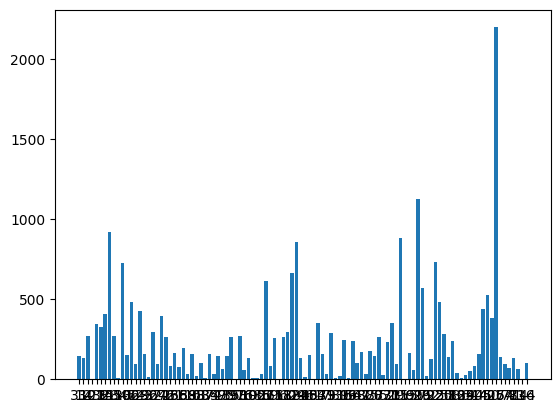

Max value: 99


In [48]:
x_ages = list(set(ages))
y_ages = [ages.count(i) for i in x_ages]
plt.bar(x_ages, y_ages)
plt.show()
print("Max value:", max(ages))

Género: 0 Age: 90


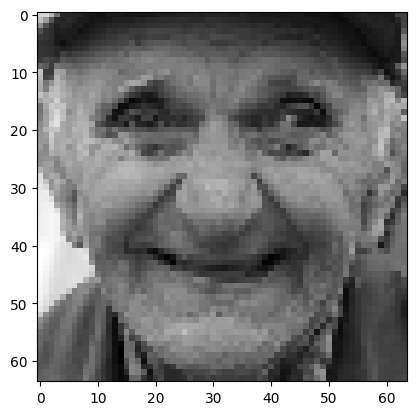

In [49]:
def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()

idx = np.random.randint(0, len(images))
sample = images[idx]
print("Género:", genders[idx], "Age:", ages[idx])
display(sample)


In [51]:
def age_group(age):
    if age >= 0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4

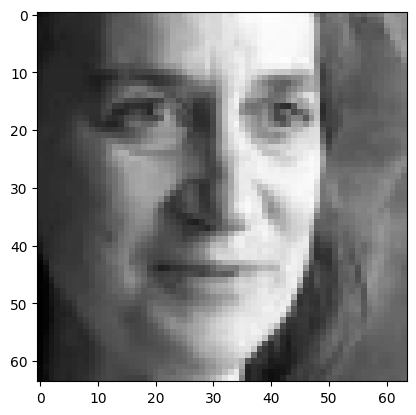

In [52]:
#preprocesamiento
target = np.zeros((size,2), dtype='float32')
features = np.zeros((size, sample.shape[0], sample.shape[1], 1), dtype='float32')
for i in range(size):
    target[i,0] = age_group(int(ages[i])) / 4
    target [i,1] = int(genders[i])
    features[i] = images[i]

features = features / 255
display(features[np.random.randint(0, len(features))])

In [53]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=True)
print("Muestras de Entrenamiento:", x_train.shape[0])
print("Muestras de Testing:", x_test.shape[0])

Muestras de Entrenamiento: 18966
Muestras de Testing: 4742


In [54]:
print("Shape de imagen:", sample.shape)

Shape de imagen: (64, 64, 1)


In [55]:
inputs = Input(shape=(sample.shape[0], sample.shape[1], 1))
conv1 = Conv2D(32, kernel_size=(3,3), activation='relu')(inputs)
conv2 = Conv2D(64, kernel_size=(3,3), activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2,2))(conv2)
conv3 = Conv2D(128, kernel_size=(3,3), activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2,2))(conv3)
x = Dropout(0.25)(pool2)
flat = Flatten()(x)

dropout = Dropout(0.5)
age_model = Dense(128, activation='relu')(flat)
age_model = dropout(age_model)
age_model = Dense(64, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(32, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(1, activation='relu')(age_model)

dropout = Dropout(0.5)
gender_model = Dense(128, activation='relu')(flat)
gender_model = dropout(gender_model)
gender_model = Dense(64, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(32, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(16, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(8, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(1, activation='sigmoid')(gender_model)


In [56]:
model = Model(inputs=inputs, outputs=[age_model, gender_model])
model.compile(optimizer='adam', loss=['mse', 'binary_crossentropy'], metrics=['accuracy'])

In [57]:
# Entrenamiento
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 62, 62, 32)   320         ['input_6[0][0]']                
                                                                                                  
 conv2d_11 (Conv2D)             (None, 60, 60, 64)   18496       ['conv2d_10[0][0]']              
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 30, 30, 64)  0           ['conv2d_11[0][0]']              
                                                                                            

In [58]:
history = model.fit(x_train, [y_train[:,0], y_train[:,1]], validation_data=(x_test, [y_test[:,0], y_test[:,1]]), epochs=25, batch_size=128, shuffle=True)

Epoch 1/25
149/149 [==============================] - 354s 2s/step - loss: 0.8271 - dense_13_loss: 0.1335 - dense_19_loss: 0.6936 - dense_13_accuracy: 0.0119 - dense_19_accuracy: 0.5165 - val_loss: 0.7324 - val_dense_13_loss: 0.0403 - val_dense_19_loss: 0.6921 - val_dense_13_accuracy: 0.0306 - val_dense_19_accuracy: 0.5205
Epoch 2/25
149/149 [==============================] - 349s 2s/step - loss: 0.7272 - dense_13_loss: 0.0516 - dense_19_loss: 0.6757 - dense_13_accuracy: 0.0183 - dense_19_accuracy: 0.5860 - val_loss: 0.6381 - val_dense_13_loss: 0.0269 - val_dense_19_loss: 0.6112 - val_dense_13_accuracy: 0.0295 - val_dense_19_accuracy: 0.7655
Epoch 3/25
149/149 [==============================] - 348s 2s/step - loss: 0.6211 - dense_13_loss: 0.0444 - dense_19_loss: 0.5767 - dense_13_accuracy: 0.0202 - dense_19_accuracy: 0.7222 - val_loss: 0.4611 - val_dense_13_loss: 0.0267 - val_dense_19_loss: 0.4344 - val_dense_13_accuracy: 0.0318 - val_dense_19_accuracy: 0.8258
Epoch 4/25
149/149 [=====

In [59]:
model.save('data.h5')

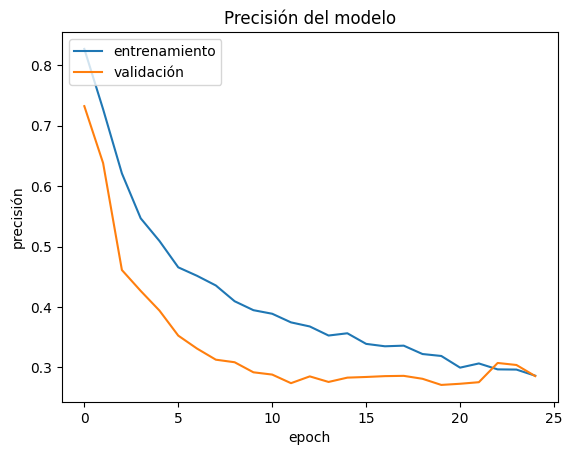

In [60]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Precisión del modelo')
plt.ylabel('precisión')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

In [64]:
def get_age(distr):
    distr = distr*4
    if distr >= 0.65 and distr <= 1.4:
        return "0-18"
    if distr >= 1.65 and distr <= 2.4:
        return "19-30"
    if distr >= 2.65 and distr <= 3.4:
        return "31-80"
    if distr >= 3.65 and distr <= 4.4:
        return "80 +"
    return "Unknown"

def get_gender(prob):
    return "Male" if prob < 0.5 else "Female"

def get_result(sample):
    sample = sample/255
    val = model.predict(np.array([sample]))
    age = get_age(val[0])
    gender = get_gender(val[1])
    print("Valores:", val, "\nPredicción de Género:", gender, "Predicción de edad:", age)
    

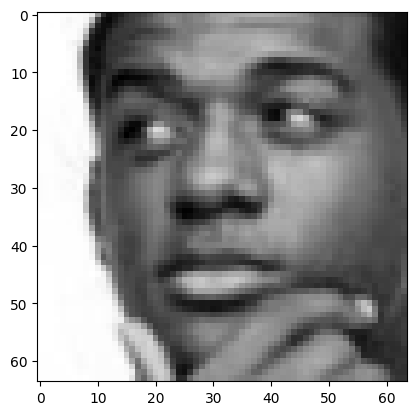

Género Actual: Male Edad: 26
1/1 [==============================] - 0s 71ms/step
Valores: [array([[0.5829114]], dtype=float32), array([[0.11953413]], dtype=float32)] 
Predicción de Género: Male Predicción de edad: 19-30


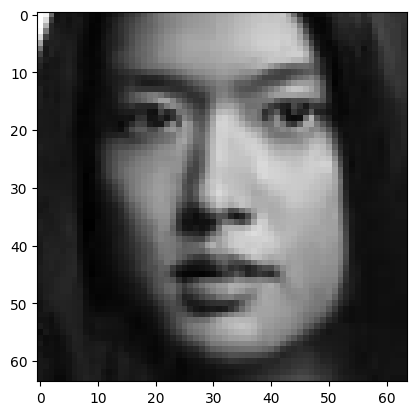

Género Actual: Female Edad: 23
1/1 [==============================] - 0s 48ms/step
Valores: [array([[0.53810185]], dtype=float32), array([[0.98808634]], dtype=float32)] 
Predicción de Género: Female Predicción de edad: 19-30


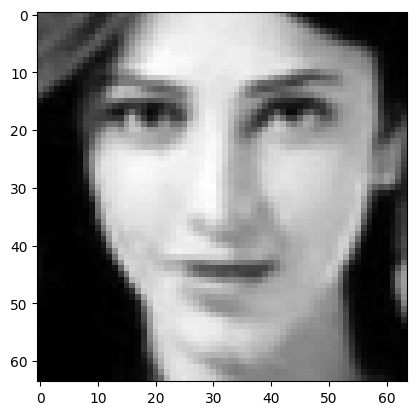

Género Actual: Female Edad: 22
1/1 [==============================] - 0s 71ms/step
Valores: [array([[0.5158989]], dtype=float32), array([[0.9987298]], dtype=float32)] 
Predicción de Género: Female Predicción de edad: 19-30


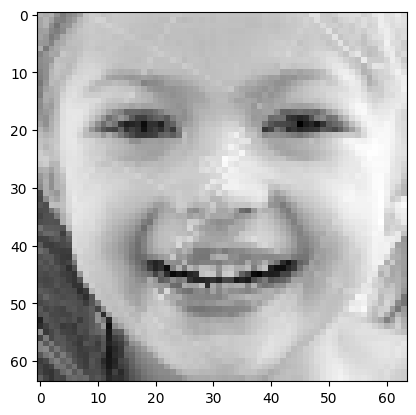

Género Actual: Female Edad: 7
1/1 [==============================] - 0s 67ms/step
Valores: [array([[0.41644442]], dtype=float32), array([[0.77369314]], dtype=float32)] 
Predicción de Género: Female Predicción de edad: 19-30


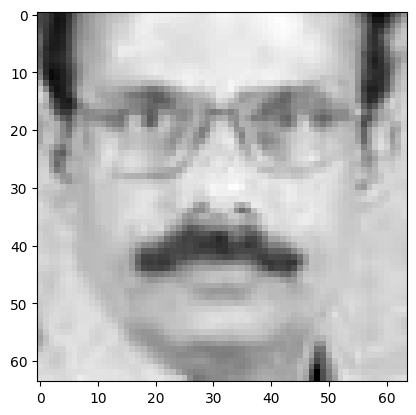

Género Actual: Male Edad: 60
1/1 [==============================] - 0s 47ms/step
Valores: [array([[0.7200544]], dtype=float32), array([[0.00055525]], dtype=float32)] 
Predicción de Género: Male Predicción de edad: 31-80


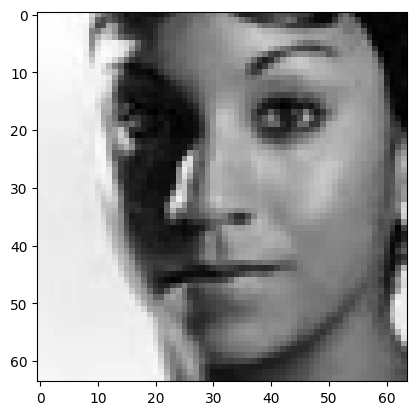

Género Actual: Female Edad: 28
1/1 [==============================] - 0s 44ms/step
Valores: [array([[0.6493453]], dtype=float32), array([[0.9310496]], dtype=float32)] 
Predicción de Género: Female Predicción de edad: Unknown


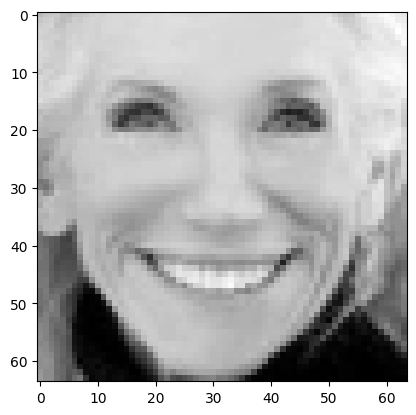

Género Actual: Female Edad: 72
1/1 [==============================] - 0s 51ms/step
Valores: [array([[0.701288]], dtype=float32), array([[0.99328417]], dtype=float32)] 
Predicción de Género: Female Predicción de edad: 31-80


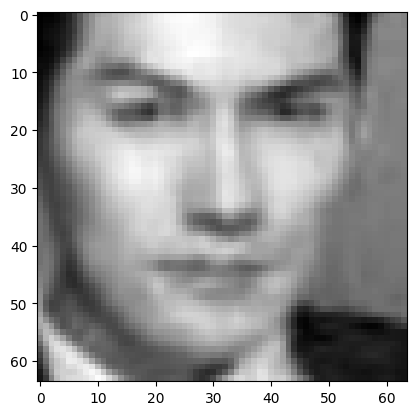

Género Actual: Male Edad: 32
1/1 [==============================] - 0s 50ms/step
Valores: [array([[0.5957788]], dtype=float32), array([[0.01103965]], dtype=float32)] 
Predicción de Género: Male Predicción de edad: 19-30


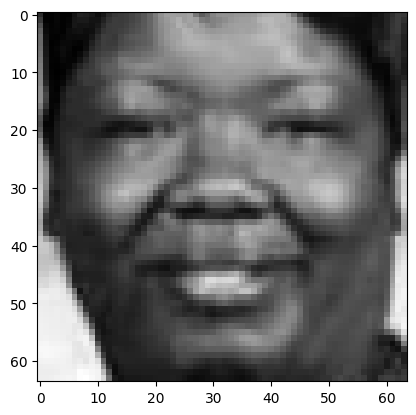

Género Actual: Female Edad: 42
1/1 [==============================] - 0s 40ms/step
Valores: [array([[0.6437789]], dtype=float32), array([[0.93708605]], dtype=float32)] 
Predicción de Género: Female Predicción de edad: Unknown


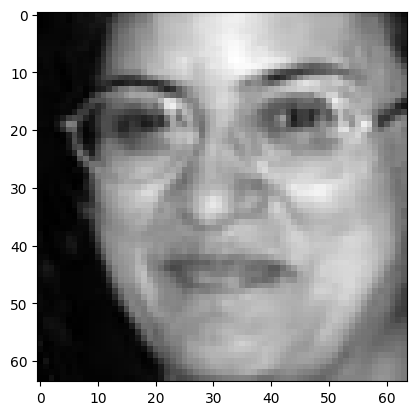

Género Actual: Female Edad: 42
1/1 [==============================] - 0s 44ms/step
Valores: [array([[0.6831577]], dtype=float32), array([[0.99796015]], dtype=float32)] 
Predicción de Género: Female Predicción de edad: 31-80


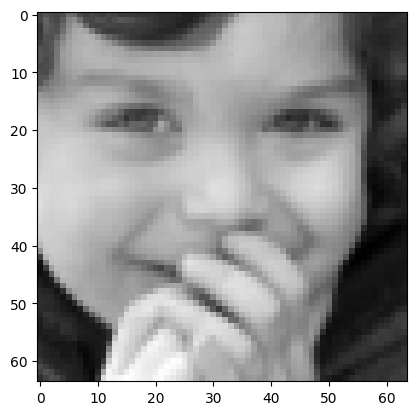

Género Actual: Male Edad: 4
1/1 [==============================] - 0s 47ms/step
Valores: [array([[0.4457801]], dtype=float32), array([[0.5658641]], dtype=float32)] 
Predicción de Género: Female Predicción de edad: 19-30


In [67]:
#Examples
indexes = [np.random.randint(0, len(images)) for _ in range(11)]
for i in indexes:
    sample = images[i]
    display(sample)
    print("Género Actual:", get_gender(genders[i]), "Edad:", ages[i])
    result = get_result(sample)
